# Problem Set 3

# Constants
Set these to make things run faster. In order to use the maximum of these constants, just set them to `None`.

In [1]:
NUM_CASES = 1000 # Number of cases (spacys tokenization is quite slow)

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt

# Display plots directly inline
%matplotlib inline

# Load data

In [3]:
import os
import numpy as np
import pandas as pd
from zipfile import ZipFile

def counter_message(cnt, max_cnt, action):
    """Display Progress
    """   
    #Print Message
    print("\r{}/{}: {}.".format(cnt, max_cnt, action), end=" "*10, flush=True)

    
# Load metadata
judge_ids = {}
is_republican = {}
case_reversed = {}

metadata = pd.read_csv("data/case_metadata.csv")
metadata = metadata.dropna(axis='index', how='any') # remove rows with missing values

for caseid, case_rev, judge_id, year, x_republican, log_cites in metadata.values:
    judge_ids[caseid] = int(judge_id)
    is_republican[caseid] = x_republican
    case_reversed[caseid] = case_rev

    
# Load case data
zfile = ZipFile("data/cases.zip")

caseids = []
raw_texts = {}
years = {}


# Randomly shuffle files and choose as many as we need
files = zfile.namelist()
files = np.random.permutation(files)

if NUM_CASES is None:
    NUM_CASES = len(files)
NUM_CASES = min(NUM_CASES, len(metadata))


cnt = 0
for case in files:
    if cnt >= NUM_CASES:
        break
    year, caseid = case[:-4].split("_")
    if caseid in metadata['caseid'].values:
        cnt += 1
        with zfile.open(case) as f:
            raw_texts[caseid] = f.read().decode()
        years[caseid] = int(year)
        caseids.append(caseid)
        counter_message(cnt, NUM_CASES, "opened")


1000/1000: opened.          

Convert to `spacy` documents:

In [4]:
import spacy
nlp = spacy.load('en') # requires:python -m spacy download en

spacy_documents = {}
for cnt, caseid in enumerate(caseids, start=1):
    spacy_documents[caseid] = nlp(raw_texts[caseid])
    counter_message(cnt, NUM_CASES, "converted")
    

1000/1000: converted.          

# Preprocessing


In [31]:
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))

normalized_docs = {}
adjectives = set()

for cnt, caseid in enumerate(caseids, start=1):
    spacy_document = spacy_documents[caseid]
    normalized_docs[caseid] = []
    for sent in spacy_document.sents:
        normalized_sent = []
        for token in sent:
            if (not token.is_punct) and (not token.is_space) and (token not in stoplist): 
                normalized_sent.append(token.lower_)
            if token.pos_ == "ADJ":
                adjectives.add(token.lower_)
        if normalized_sent:
            normalized_docs[caseid].append(normalized_sent)
            
    counter_message(cnt, NUM_CASES, "normalized")

1000/1000: normalized.          

# Exercise 1

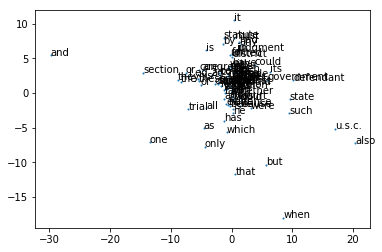

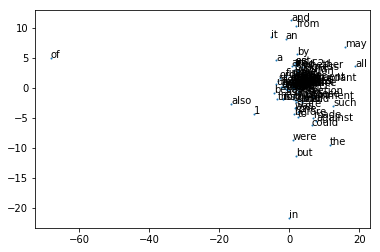

In [12]:
import itertools as itt
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

sentences = list(itt.chain.from_iterable(normalized_docs.values()))

# I expect the smaller window size to produce less qualitative, but more localized word embeddings, such that only
# immediate neighbors are forced to be close together, whereas the long window size will have a more global
# perspective, but word ordering will not matter as much.

for window_size in (2, 16):
    w2v = Word2Vec(
        sentences,
        min_count = 5,
        window = window_size,
        size = 50,
        workers = 8,
        iter = 25,
        )
    word_vectors = w2v.wv.vectors[:100]
    projected = TSNE(n_components=2, perplexity=50, n_iter=350).fit_transform(word_vectors)
    plt.figure()
    plt.scatter(projected[:, 0], projected[:, 1], s=1)
    for xy, word in zip(projected, w2v.wv.index2word[:100]):
        plt.annotate(word, xy=xy)

# Exercise 2

In [37]:
for rep in (True, False):

    sentences = list(itt.chain.from_iterable(v for k, v in normalized_docs.items() if is_republican[k]))
    w2v = Word2Vec(
        sentences,
        min_count = 5,
        window = 8,
        size = 50,
        workers = 8,
        iter = 25,
        )
    print('---------------------')
    print('REPUBLICAN' if rep else 'DEMOCRAT')
    print('---------------------')
    for word in ('abortion', 'gun', 'immigrant', 'drugs', 'church', 'race', 'tax'):
        print('Most similar to {}'.format(word))
        print([w for w, _ in w2v.most_similar(word, topn=100) if w in adjectives][:10])
        print()

# There are a number of differences in adjectives for each party, which reflect the political positions of the judges.

---------------------
REPUBLICAN
---------------------
Most similar to abortion
['minor', 'physician', 'unemancipated', 'pregnant', 'unmarried', 'parental', 'mature', 'alien', 'complainant', 'absolute']

Most similar to gun
['shotgun', 'rear', 'near', 'buttitta', 'parked', 'deadly', 'wound', 'front', 'empty', 'inside']

Most similar to immigrant
['alien', 'nonimmigrant', 'asylum', 'reemployment', 'unapproved', 'nolo', 'vietnamese', 'contendere', 'designate', 'inmate']

Most similar to drugs
['dangerous', 'illegal', 'paraphernalia', 'generic', 'morphine', 'mixed', 'pin', 'associated', 'infected', 'reproducing']

Most similar to church
['jewish', 'worldwide', 'universal', 'democratic', 'star', 'precious', 'christian', 'inland', 'electrical', 'amateur']

Most similar to race
['racial', 'religious', 'ethnic', 'color', 'political', 'electoral', 'segregated', 'institutional', 'discriminatory', 'official']

Most similar to tax
['taxable', 'collected', 'impounded', 'lien', 'excise', 'premium',